In [3]:
# need to install the following packages using pip3:
# pip3 install numpy pandas matplotlib mplhep shapely

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

#Improves the style of the plots in matplotlib
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import os
if not os.path.exists("images"):
    os.mkdir("images")

In [2]:
import design_parameters as dp

In [3]:
print(dp.coord_thickness, dp.n_layers)

2.0500000000000003 60


In [4]:
#calculate the "hexagon root" and the "hexagoned" functions 
#(analogous to the square root and the squared functions)
def hxrt(A):
    return np.sqrt(A/(3*np.sqrt(3)/2))
def hexed(sl):
    return sl**2*3*np.sqrt(3)/2

In [7]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union

def cell_positions(layer, boundary, sidelength=1.889, debug=False, wall_thickness=dp.wall_thickness, 
                   wall_scint_gap=dp.wall_scint_gap, stagger=True, shiftY=0, shiftX=0):
    if wall_thickness!=0:
        boundary=boundary.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(boundary.exterior.xy[1])
    
    nrows = int((max(boundary.exterior.xy[1])-min(boundary.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+3)
    
    y0=(max(boundary.exterior.xy[1])+min(boundary.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(boundary.exterior.xy[0])-min(boundary.exterior.xy[0]))/(sidelength*3/2))+3
    x0=min(boundary.exterior.xy[0])
    
    
    
    # x,y are the position of the SiPM and dimple center
    
    d={a:[] for a in "x y row col boundsx boundsy area scint_boundsx scint_boundsy scint_area".split()}
    
    if stagger: #ignore the existing shiftX and shiftY
        shiftX+=[-sidelength*3/4, 0,0, sidelength*3/4][layer%4] 
        shiftY+=[0,sidelength*np.sqrt(3)/4, -sidelength*np.sqrt(3)/4, 0][layer%4]
    #print(shiftX)
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(-1, ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if boundary.contains(hexagon):
                d['x'].append(x)
                d['y'].append(y)
                d['row'].append(i)
                d['col'].append(j)
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell itself (ie, minus the frame or ESR wrap)
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
    df=pd.DataFrame(d)
    
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={boundary.area}, ratio= {sum(df.area)/boundary.area}")
    return df
    
            

In [8]:
def print_summary_stats(df, boundary):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=boundary.area
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"area covered by regular hexagons: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"# of regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")
    
    scint_area=sum(df.scint_area)
    scint_hex_area=sum(df.query("augmented==0 and cropped==0").scint_area)
    
    print(f"scintillator area: {scint_area} cm^2")
    print(f"dead area: {tot_area-scint_area:.1f} cm^2  ({100*(tot_area-scint_area)/scint_area:.1f}%)")
    
    
    print(f"area covered by regular hexagon scintillators: {scint_hex_area:.1f} cm^2 ({100*scint_hex_area/tot_area:.1f}% of total)")
    
    

In [37]:
#now tabulate all layers, and also create a dataframe that contains the summary variables
all_layers ={}
all_bounds={}
absorber_material=dp.absorber_material

columns=[]
columns+="layer side deadzone_frac channels reg_hexes sidelength absorber_material".split()
columns+="tot_area scint_area deadzone_area area".split()
d={a:[] for a in columns}

nsmalllayers=16
#hardcoded numbers finetuned to get the maximal coverage.  
for layer in range(1,60+1):
    for side in "LR":
        
        #physical boundary of the PCBs
        real_bounds=dp.layer_boundaries(layer, side)
        if layer <=nsmalllayers:
            sidelength=2.34
            shiftX=sidelength*.5235 if side=="L" else sidelength*.2501
            shiftY=0#sidelength*np.sqrt(3)/2 if side=="L" else sidelength*np.sqrt(3)/2*0
            
            stagger=True
        else:
            if side=="L":
                sidelength=2.84
                w=np.max(real_bounds.exterior.xy[0])-np.min(real_bounds.exterior.xy[0])
                shiftX=w-(w//sidelength)*sidelength+sidelength*.47
                shiftY=sidelength*np.sqrt(3)/2
            if side=="R":
                sidelength=3.1
                shiftX=-sidelength*.495  
                shiftY=sidelength*np.sqrt(3)/2*0
            stagger=False
        # calculate the cell positions with cells allowed to cross the edge of the PCB on the inside
        # but not on the outside
        inner_tolerance=sidelength*0#.33
        bounds_with_inner_tolerance=dp.layer_boundaries(layer, side, inner_tolerance=inner_tolerance)
        
        
        df_layer_side=cell_positions(layer, bounds_with_inner_tolerance, 
                                     sidelength=sidelength, 
                                     stagger=stagger,
                                     shiftX=shiftX,
                                     shiftY=shiftY)
        all_bounds[(layer,side)]=real_bounds
        all_layers[(layer, side)]=df_layer_side
        d['layer'].append(layer)
        d['side'].append(side)
        tot_area=real_bounds.area
        d['tot_area'].append(tot_area)
        scint_area=sum(df_layer_side.scint_area)
        d['scint_area'].append(scint_area)
        area=sum(df_layer_side.area)
        d['area'].append(area)
        deadzone_area=tot_area-scint_area
        d['deadzone_area'].append(deadzone_area)
        
        deadzone_frac = deadzone_area/tot_area
        d['deadzone_frac'].append(deadzone_frac)
        
        d['channels'].append(len(df_layer_side))
        d['reg_hexes'].append(len(df_layer_side))
        d['sidelength'].append(sidelength)
        d['absorber_material'].append(absorber_material[layer])
        
summary=pd.DataFrame(d)

print("total channels:", sum(summary.channels))
for side in "LR":
    nhg=sum(summary.query(f"side=='{side}' and layer<={nsmalllayers}").channels)
    print(f"{side}, layers 1-{nsmalllayers}: {nhg} channels, ({nhg/nsmalllayers:.1f} channels/layer avg)")
    nlg=sum(summary.query(f"side=='{side}' and layer>{nsmalllayers}").channels)
    print(f"{side}, layers {nsmalllayers+1}-60: {nlg} channels, ({nlg/(60-nsmalllayers):.1f} channels/layer avg)")
    print(f"{side}, all layers: {nlg+nhg} channels, ({(nlg+nhg)/60:.1f} channels/layer avg)")
print(f"deadzone fraction: {100-100*sum(summary.area)/sum(summary.tot_area):.1f}%")
print(f"deadzone fraction (small-cell layers):  {100-100*sum(summary.area[:nsmalllayers])/sum(summary.tot_area[:nsmalllayers]):.1f}%")

print(f"deadzone fraction (large-cell layers):  {100-100*sum(summary.area[nsmalllayers:])/sum(summary.tot_area[nsmalllayers:]):.1f}%")
for s in "LR":
    print(f"deadzone fraction (large-cell layers, {s}):  {100-100*sum(summary.area[nsmalllayers:][summary.side==s])/sum(summary.tot_area[nsmalllayers:][summary.side==s]):.1f}%")
      

total channels: 6312
L, layers 1-16: 856 channels, (53.5 channels/layer avg)
L, layers 17-60: 1716 channels, (39.0 channels/layer avg)
L, all layers: 2572 channels, (42.9 channels/layer avg)
R, layers 1-16: 1536 channels, (96.0 channels/layer avg)
R, layers 17-60: 2204 channels, (50.1 channels/layer avg)
R, all layers: 3740 channels, (62.3 channels/layer avg)
deadzone fraction: 23.1%
deadzone fraction (small-cell layers):  24.2%
deadzone fraction (large-cell layers):  22.9%
deadzone fraction (large-cell layers, L):  21.8%
deadzone fraction (large-cell layers, R):  23.6%


In [10]:
#now determine how many long PCBs (transfer boards) are needed.  

In [11]:
#determine how many channels exist in a layer range for a given side
def channels_in_range(layer_min, layer_max, side='R'):
    
    return sum(summary.query(f"side=='{side}' and layer>={layer_min} and layer<={layer_max}").channels)

In [12]:
for side in "RL":
    print("side ",side)
    ranges=[]
    lmax=60
    for i in reversed(range(1,60+1)):
        lmin=i
        #max_channels_per_board=108*6
        height_in_cm=12
        max_channels_per_layer=int(height_in_cm/.11)
        max_channels_per_board=max_channels_per_layer*6
        a=int(np.ceil(channels_in_range(lmin, lmax,side)/2)) # divide by two because we want the numbers for each quadrant
        if a>max_channels_per_board:
            ranges.append((lmin+1,lmax,channels_in_range(lmin+1, lmax, side)/2))
            lmax=lmin
        if i==1:
            ranges.append((lmin,lmax,channels_in_range(lmin, lmax,side)/2))

    ranges=reversed(ranges)
    pins_per_connector=500

    #each copper layer can hold 12 cm/1.1 mm = 108 channels
    for mn,mx,ch in ranges:
        120/1.1
        print(f"layers {mn}-{mx} ({ch} channels per board, {ch/max_channels_per_layer:.2f} Cu layers, {ch/(pins_per_connector/2):.2f} connectors)")
    

side  R
layers 1-13 (628.5 channels per board, 5.77 Cu layers, 2.51 connectors)
layers 14-34 (612.5 channels per board, 5.62 Cu layers, 2.45 connectors)
layers 35-60 (629.0 channels per board, 5.77 Cu layers, 2.52 connectors)
side  L
layers 1-27 (642.5 channels per board, 5.89 Cu layers, 2.57 connectors)
layers 28-60 (643.5 channels per board, 5.90 Cu layers, 2.57 connectors)


## now make some plots showing the layouts we have made.  

In [16]:
def draw_layer(layer, R_readout=0.4, fillDimple=True, color=None, shade_deadzone=True, linewidth=None):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    if color == None:
        color='krbg'[layer%4] 
    
    for side in "LR":
        boundaries=all_bounds[(layer,side)]
        #print(boundaries)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color, linewidth=linewidth)
        
        #draw the deadzone
        df=all_layers[(layer, side)]
        dz=boundaries
        for j in range(len(df)):
            dz-=Polygon(zip(df.boundsx[j],df.boundsy[j])).buffer(.001)
        for tb in -1,1:
            #split it into two parts, so that there are no holes
            dzhalf=dz-Polygon(((-100,0),(100,0),(100,-100*tb),(-100, -100*tb),(-100, 0)))
            if shade_deadzone:
                if type(dzhalf)!=MultiPolygon:
                    plt.gca().add_patch(mpl.patches.Polygon(list(zip(*dzhalf.exterior.xy)),color=color,alpha=0.2,
                       zorder=-1))
                else:
                    for poly in dzhalf.geoms:
                        plt.gca().add_patch(mpl.patches.Polygon(list(zip(*poly.exterior.xy)),color=color,alpha=0.2,
                       zorder=-1))
                        
        
        #plt.gca().add_patch(mpl.patches.Polygon(list(zip(*boundaries.exterior.xy)), linestyle='-', color=color,alpha=0.5,
        #                   zorder=-1))
        for i in range(len(df)):
            plt.plot(df.boundsx[i], df.boundsy[i], color=color, linewidth=linewidth)
            
            plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                      linestyle='' if fillDimple else '-',
                                                    fill=fillDimple, linewidth=linewidth))

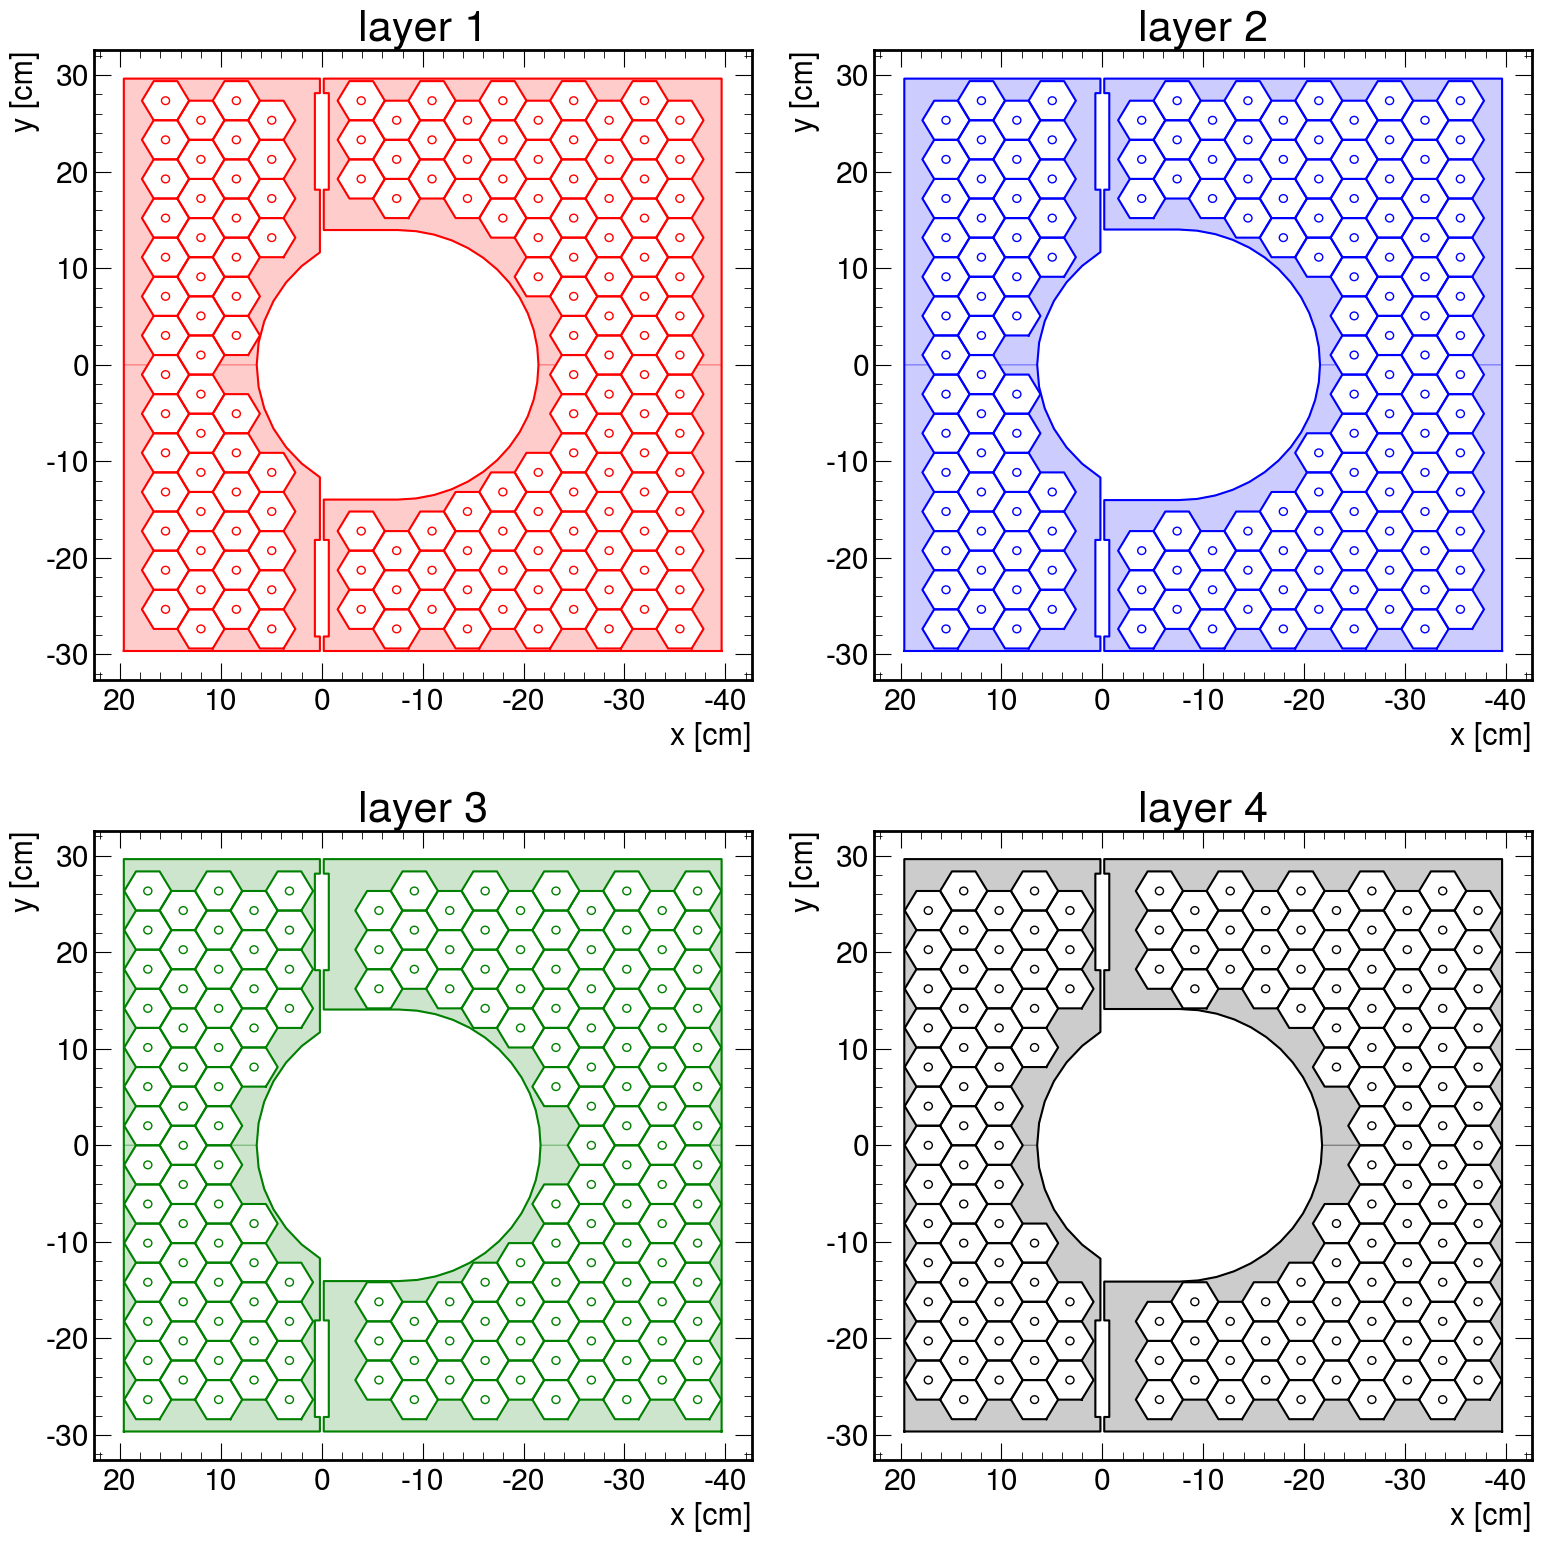

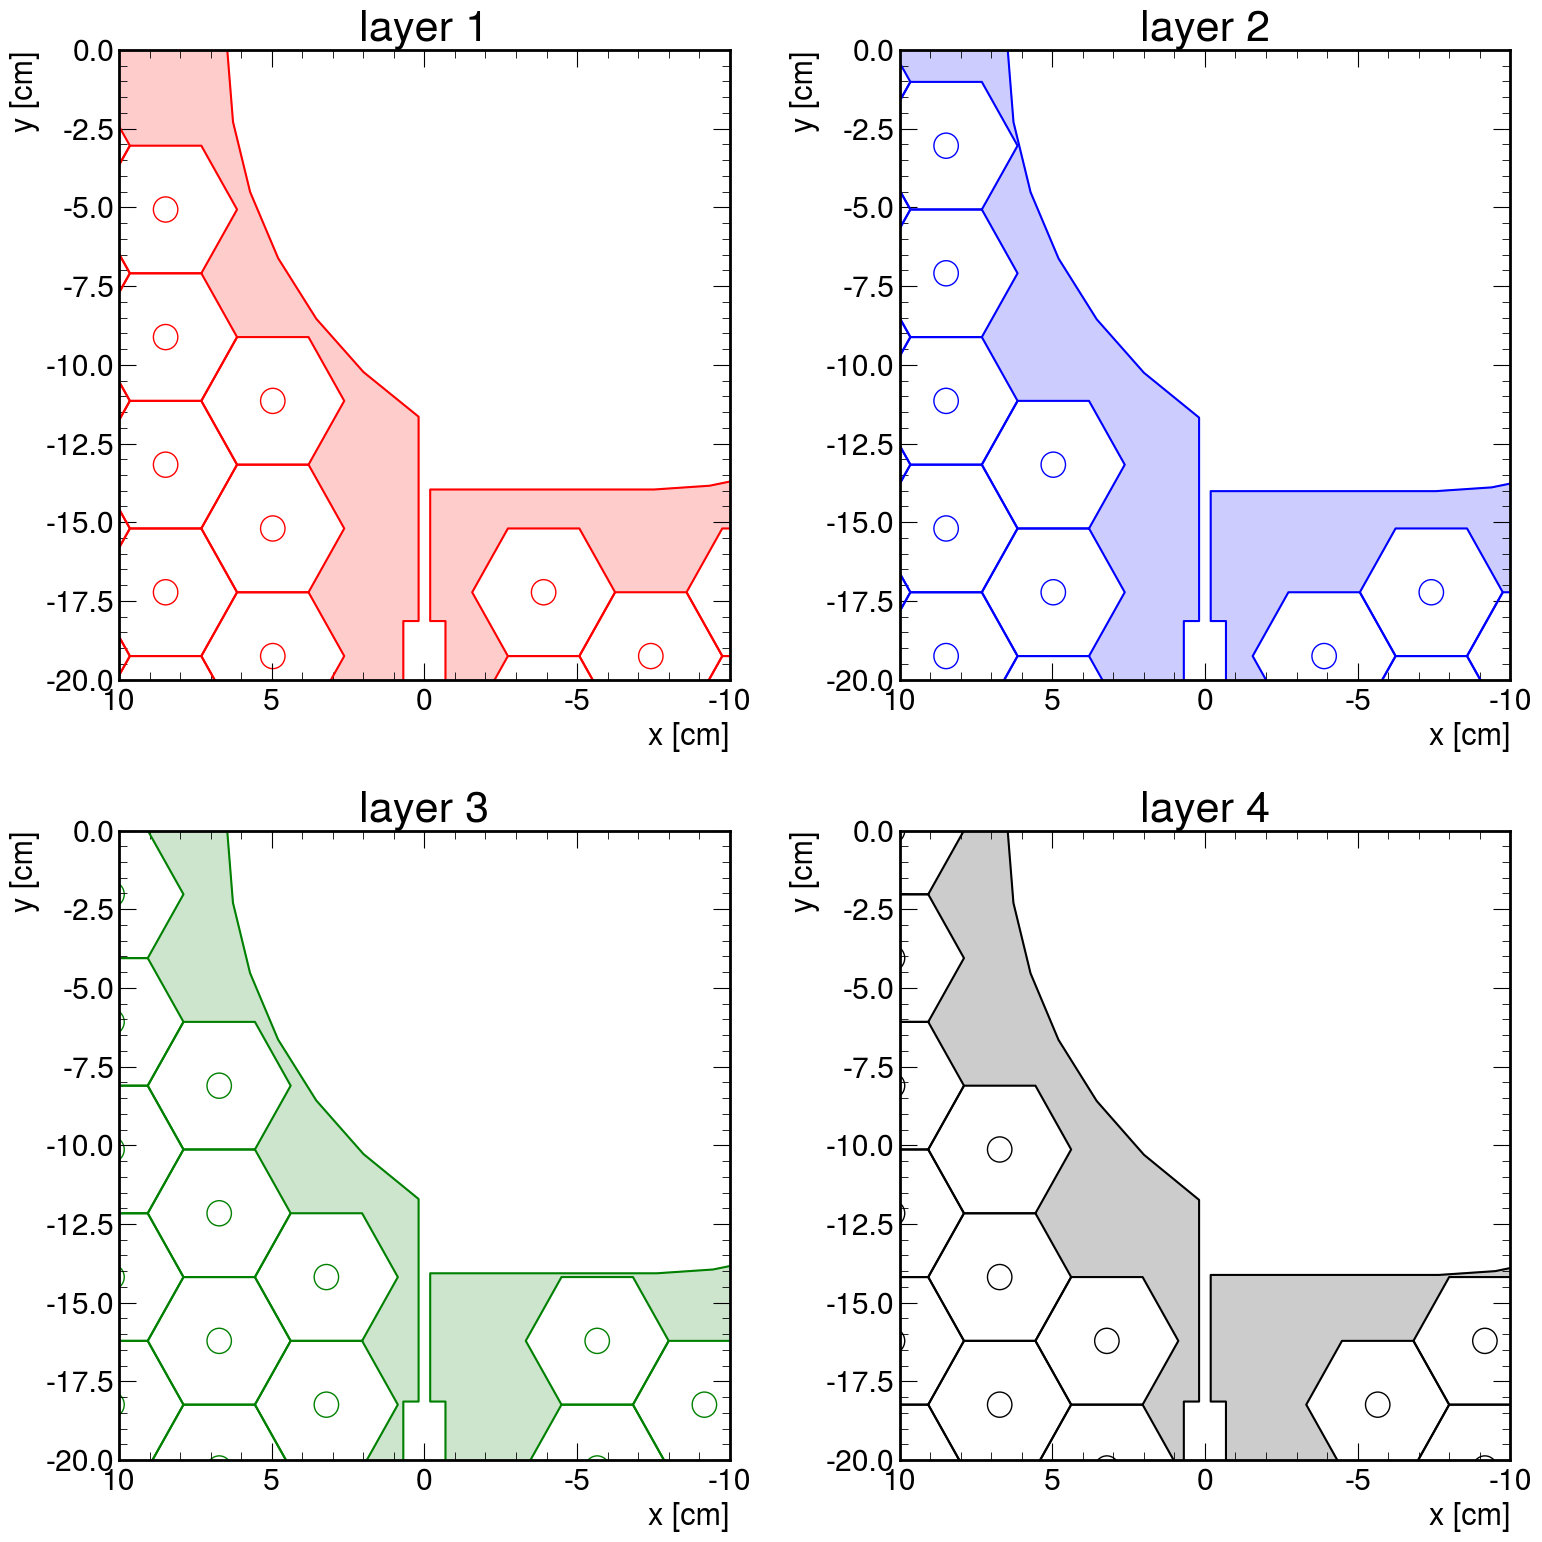

In [17]:
for layer_offset in 1,:
    for zoom in False, True:
        arg=dict(fillDimple=False)
        
        fig,axs=plt.subplots(2,2, figsize=(16,16))
        for i in range(4):

            plt.sca(axs[i//2][i%2])
            plt.title(f"layer {i+layer_offset}")
            draw_layer(i+layer_offset, **arg)
            plt.gca().invert_xaxis()
            #plt.sca(axs[1][1])
            #plt.title(f"layers 0-2")
            #draw_layer(i, **arg)
    #     axs[1][1].invert_xaxis()
        for row in axs:
            for ax in row:
                ax.set_xlabel("x [cm]", fontsize=22)
                ax.set_ylabel("y [cm]", fontsize=22)
                if zoom:
                    ax.set_xlim(-10, 10)
                    ax.set_ylim(-20, 0)
                    ax.invert_xaxis()
        plt.tight_layout()
        plt.savefig(f"images/Layers_{layer_offset}-{layer_offset+3}{'_zoom' if zoom else ''}.pdf")
        plt.show()

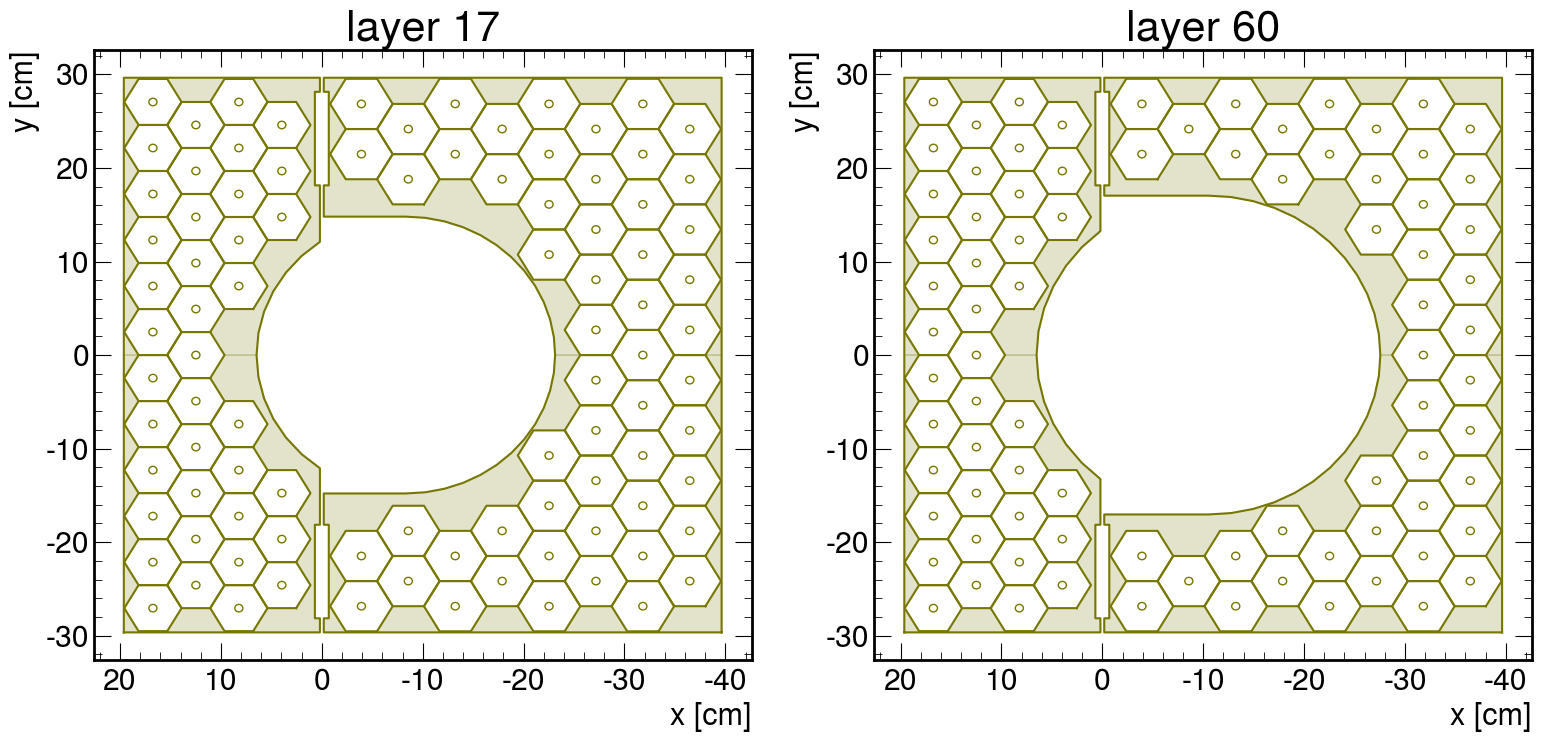

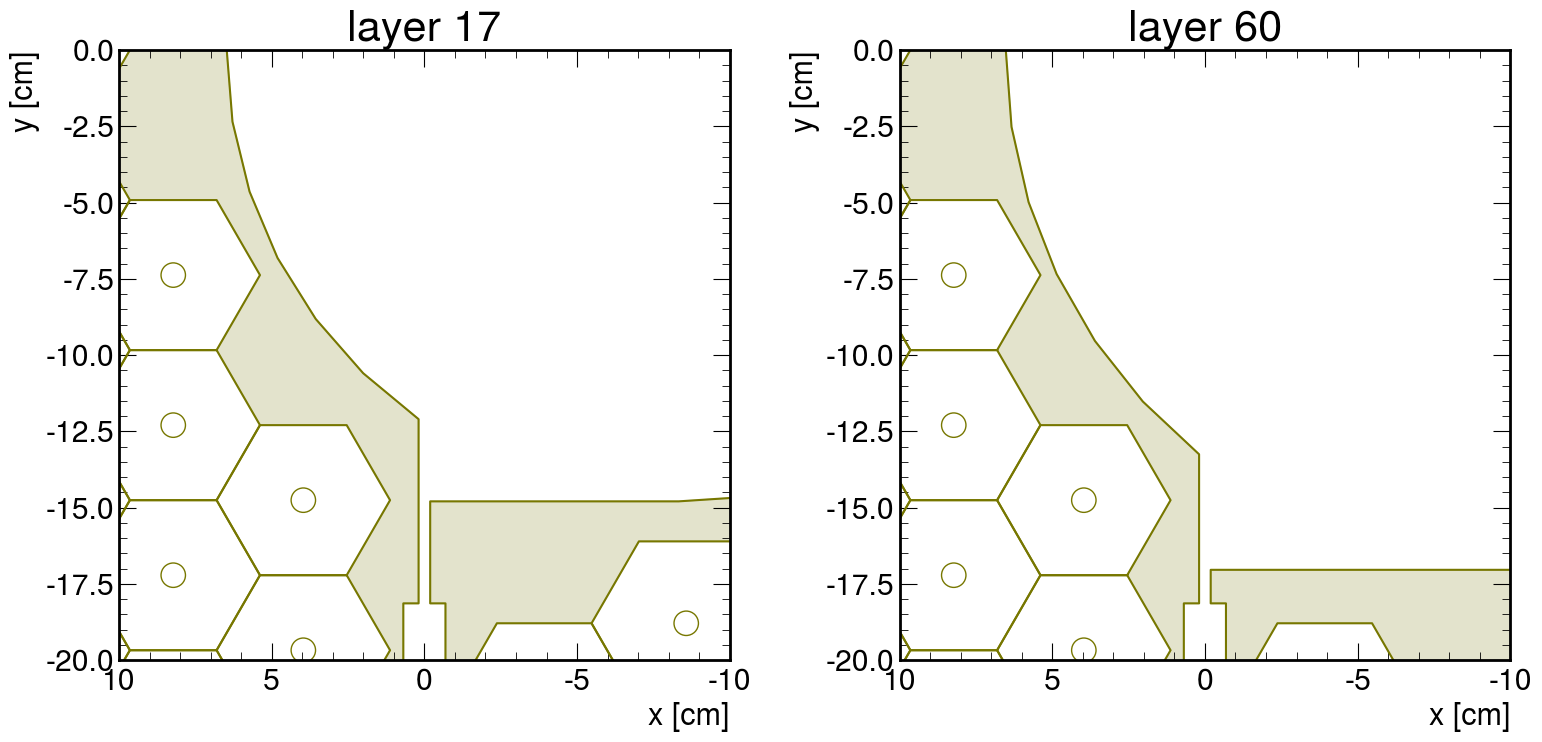

In [18]:
layers_to_draw=(17,60)
for zoom in False, True:
    arg=dict(fillDimple=False)

    fig,axs=plt.subplots(1,2, figsize=(16,8))
    for i in range(2):

        plt.sca(axs[i])
        plt.title(f"layer {layers_to_draw[i]}")
        draw_layer(layers_to_draw[i], **arg, color='#777700')
        plt.gca().invert_xaxis()
        #plt.sca(axs[1][1])
        #plt.title(f"layers 0-2")
        #draw_layer(i, **arg)
#     axs[1][1].invert_xaxis()
        for ax in axs:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)
            if zoom:
                ax.set_xlim(-10, 10)
                ax.set_ylim(-20, 0)
                ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig(f"images/Layers_17-60{'_zoom' if zoom else ''}.pdf")
    plt.show()

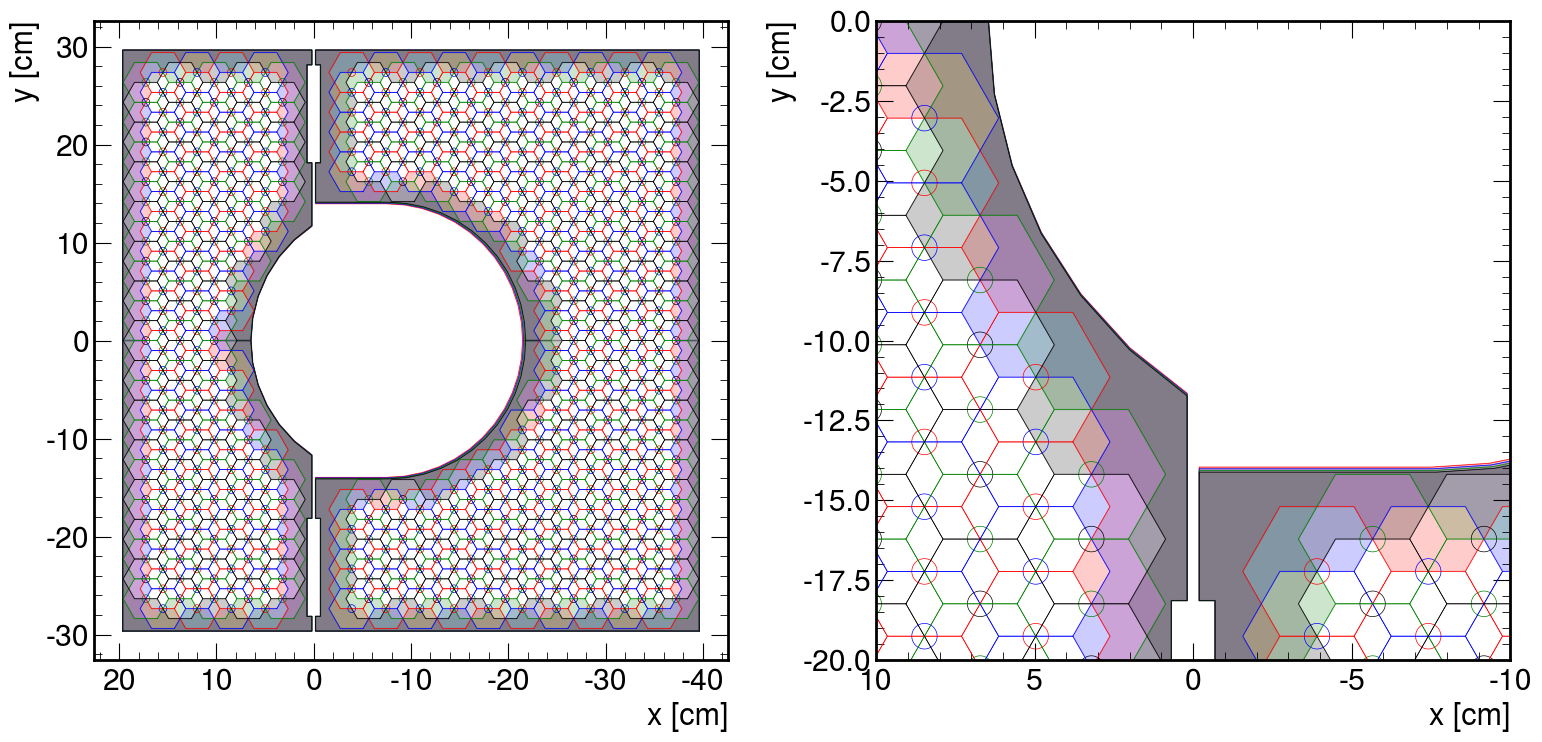

In [19]:
layer_offset= 1

fig,axs=plt.subplots(1,2, figsize=(16,8))
for zoom in False, True:
    arg=dict(fillDimple=False, shade_deadzone=True, linewidth=0.5)
    plt.sca(axs[1*zoom])
    for i in range(4):
        draw_layer(i+layer_offset, **arg)
        
        
    plt.xlabel("x [cm]", fontsize=22)
    plt.ylabel("y [cm]", fontsize=22)
    if zoom:
        plt.xlim(-10, 10)
        plt.ylim(-20, 0)
    
#     boundaries-
#                            zorder=-1))
#         df = all_layers[(layer, side)]
#         for i in range(len(df)):
#             plt.plot(df.boundsx[i], df.boundsy[i], color=color, linewidth=linewidth)
#             if shade_deadzone:
#                 plt.gca().add_patch(mpl.patches.Polygon(list(zip(df.boundsx[i], df.boundsy[i])
    plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig(f"images/Layers_{layer_offset}-{layer_offset+3}_combined.pdf")
plt.show()

# Put the locations of the cell centers and the bounds of the PCB boards into .csv files

In [48]:
import os
#help(os)
if not os.path.exists("insert_layout"):
    os.mkdir("insert_layout")
for i in range(1,60+1):
    for side in "LR":
        all_layers[(i, side)].drop(columns="boundsx boundsy scint_boundsx scint_boundsy scint_area".split())\
                .to_csv(f"insert_layout/SiPM_positions_{i}{side}.csv", float_format='%.3f')
        bounds=all_bounds[(i,side)]
        pd.DataFrame({"x":bounds.exterior.xy[0],"y":bounds.exterior.xy[1]})\
                .to_csv(f"insert_layout/PCB_edges_{i}{side}.csv", float_format='%.3f')

#check to see how many actual layouts are needed (since some layouts can be repeated for multiple layers)
#then write this info out to a csv file
layouts=[]
layers_with_layout=[]
tol=0.1
for side in "LR":
    for i in range(1,60+1):
        found=False
        for j in range(len(layouts)):
            if len(all_layers[(i,side)])==len(layouts[j]) and max(all_layers[(i,side)].x-layouts[j].x)<tol and \
                    max(all_layers[(i,side)].y-layouts[j].y)<tol:
                found=True
                break
        if not found:
            layouts.append(all_layers[(i,side)])
            layers_with_layout.append([(i,side)])
        else :
            layers_with_layout[j].append((i,side))
print(len(layouts), "layouts total")
s="side,layers"
for i in range(len(layers_with_layout)):
    side=layers_with_layout[i][0][1]
    layers=[layers_with_layout[i][j][0] for j in range(len(layers_with_layout[i]))]
    if len(layers)==1:
        layers_str=f"{layers[0]}"
    elif len(layers)==max(layers)-min(layers)+1:
        layers_str=f"{min(layers)}-{max(layers)}"
    else:
        layers_str=";".join([str(l) for l in layers])
    s+=f'\n{side},\'{layers_str}\''
print(s)
with open("insert_layout/layouts.csv", "w") as f:
    print(s, file=f)

25 layouts total
side,layers
L,'1;5'
L,'2;6'
L,'3;7;11;15'
L,'4;8;12;16'
L,'9;13'
L,'10;14'
L,'17-60'
R,'1;5'
R,'2;6'
R,'3'
R,'4'
R,'7'
R,'8;12;16'
R,'9'
R,'10'
R,'11'
R,'13'
R,'14'
R,'15'
R,'17-18'
R,'19-28'
R,'29-41'
R,'42-46'
R,'47-59'
R,'60'


Show the results for one of the boards

In [32]:

print("cat insert_layout/SiPM_positions_60L.csv")
!cat insert_layout/SiPM_positions_60L.csv
print("\ncat insert_layout/PCB_edges_60L.csv")
!cat insert_layout/PCB_edges_60L.csv 

cat insert_layout/SiPM_positions_60L.csv
,x,y,row,col,area
0,8.225,-27.055,1,1,20.955
1,16.745,-27.055,1,3,20.955
2,3.965,-24.595,2,0,20.955
3,12.485,-24.595,2,2,20.955
4,8.225,-22.136,3,1,20.955
5,16.745,-22.136,3,3,20.955
6,3.965,-19.676,4,0,20.955
7,12.485,-19.676,4,2,20.955
8,8.225,-17.217,5,1,20.955
9,16.745,-17.217,5,3,20.955
10,3.965,-14.757,6,0,20.955
11,12.485,-14.757,6,2,20.955
12,8.225,-12.298,7,1,20.955
13,16.745,-12.298,7,3,20.955
14,12.485,-9.838,8,2,20.955
15,8.225,-7.379,9,1,20.955
16,16.745,-7.379,9,3,20.955
17,12.485,-4.919,10,2,20.955
18,16.745,-2.460,11,3,20.955
19,12.485,0.000,12,2,20.955
20,16.745,2.460,13,3,20.955
21,12.485,4.919,14,2,20.955
22,8.225,7.379,15,1,20.955
23,16.745,7.379,15,3,20.955
24,12.485,9.838,16,2,20.955
25,8.225,12.298,17,1,20.955
26,16.745,12.298,17,3,20.955
27,3.965,14.757,18,0,20.955
28,12.485,14.757,18,2,20.955
29,8.225,17.217,19,1,20.955
30,16.745,17.217,19,3,20.955
31,3.965,19.676,20,0,20.955
32,12.485,19.676,20,2,20.955
33,8.225,22.136,

# miscellaneous plots relating to the eta coverage of the insert and LFHCAL

In [22]:
def eta_plot(z):
    for i,eta in enumerate(reversed(np.linspace(3.2, 4.0,9))):
              
        ls = ["--", ":", "-.", "-", (0, (3, 3, 1, 3, 1, 3)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 3, 1, 3)), (0, (5, 5)), (0,(3,1.4))][i]
        
        #for the legend
        a=plt.plot([],[], label= f"$\eta^*$={eta:.1f}", linestyle=ls, linewidth=3 if eta==3.7 else 2)
        color= a[0].get_color()
        
        
        tanTheta=np.tan(2*np.arctan(np.exp(-eta)))
        phi= np.linspace(0, 2*np.pi, 100)
        uxp = tanTheta*np.cos(phi)
        uyp = tanTheta*np.sin(phi)
        uzp = 1
        
        beamTheta=-0.025
        ux = uxp*np.cos(beamTheta)+uzp*np.sin(beamTheta)
        uy = uyp
        uz = -uxp*np.sin(beamTheta)+uzp*np.cos(beamTheta)
        
        ux/=uz
        uy/=uz
        uz/=uz
        
        
        x,y = ux*z, uy*z
        plt.plot(x, y, color=color, linestyle=ls, marker='', linewidth=3 if eta==3.7 else 2)

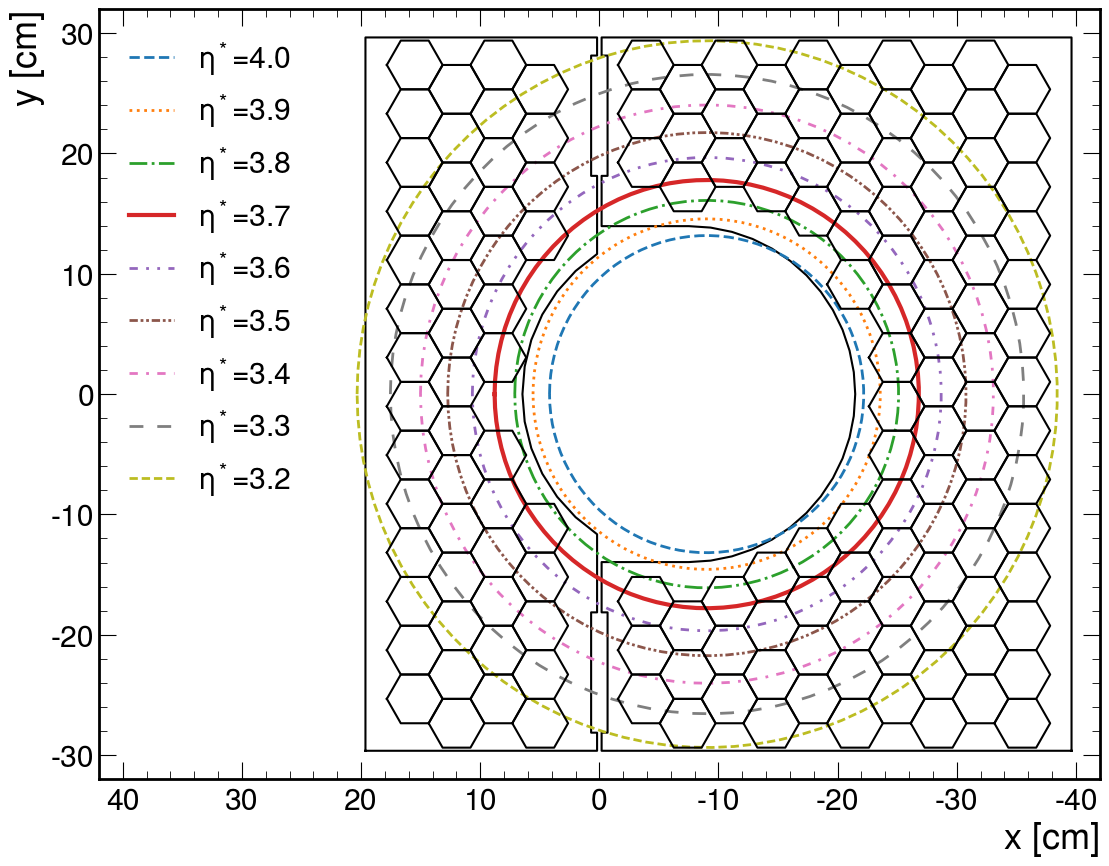

In [23]:
plt.figure(figsize=(12*113/105,10))

left_edges=pd.read_csv(f"insert_layout/PCB_edges_1L.csv")
right_edges=pd.read_csv(f"insert_layout/PCB_edges_1R.csv")

left_sipms=pd.read_csv("insert_layout/SiPM_positions_1L.csv")
right_sipms=pd.read_csv("insert_layout/SiPM_positions_1R.csv")

arg=dict(color='k')
plt.plot(left_edges.x, left_edges.y,**arg)
plt.plot(right_edges.x, right_edges.y,**arg)
eta_plot(359.6)
phi=np.linspace(0, np.pi*2, 7)
for df in left_sipms, right_sipms:
    for i in range(len(df)):
        plt.plot(np.cos(phi)*hxrt(df.area[i])+df.x[i],np.sin(phi)*hxrt(df.area[i])+df.y[i], **arg)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.gca().invert_xaxis()
plt.xlim(42, -42)
plt.ylim(-32, 32)
plt.legend(loc='upper left')
plt.show()

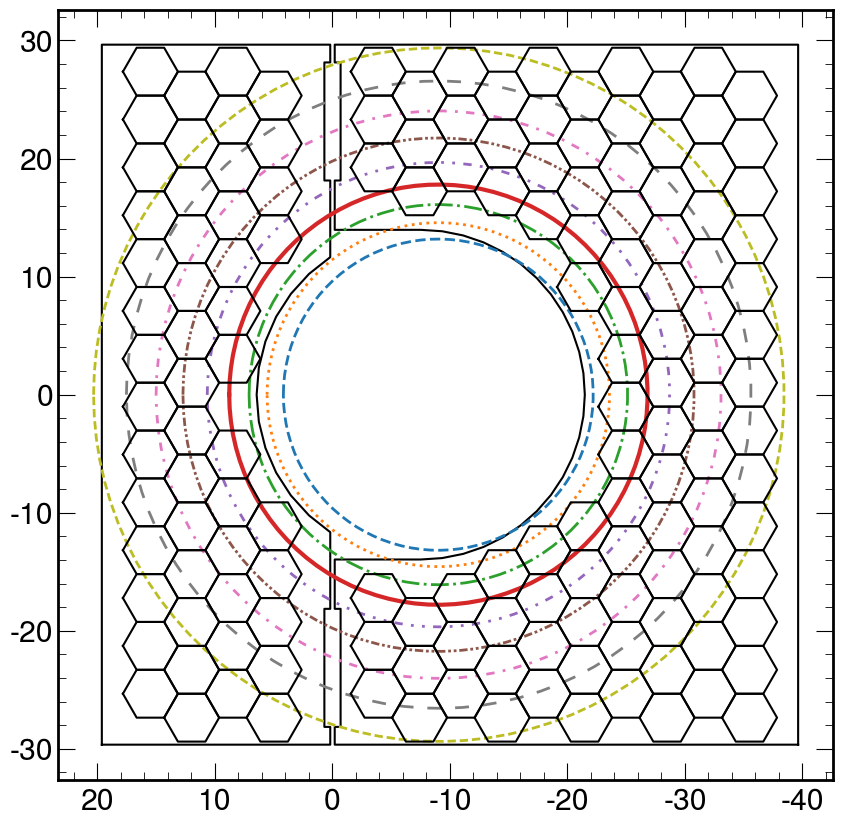

In [24]:
plt.figure(figsize=(10,10))

left_edges=pd.read_csv(f"insert_layout/PCB_edges_1L.csv")
right_edges=pd.read_csv(f"insert_layout/PCB_edges_1R.csv")

left_sipms=pd.read_csv("insert_layout/SiPM_positions_1L.csv")
right_sipms=pd.read_csv("insert_layout/SiPM_positions_1R.csv")

arg=dict(color='k')
plt.plot(left_edges.x, left_edges.y,**arg)
plt.plot(right_edges.x, right_edges.y,**arg)
eta_plot(359.6)
phi=np.linspace(0, np.pi*2, 7)
for df in left_sipms, right_sipms:
    for i in range(len(df)):
        plt.plot(np.cos(phi)*hxrt(df.area[i])+df.x[i],np.sin(phi)*hxrt(df.area[i])+df.y[i], **arg)
plt.gca().invert_xaxis()

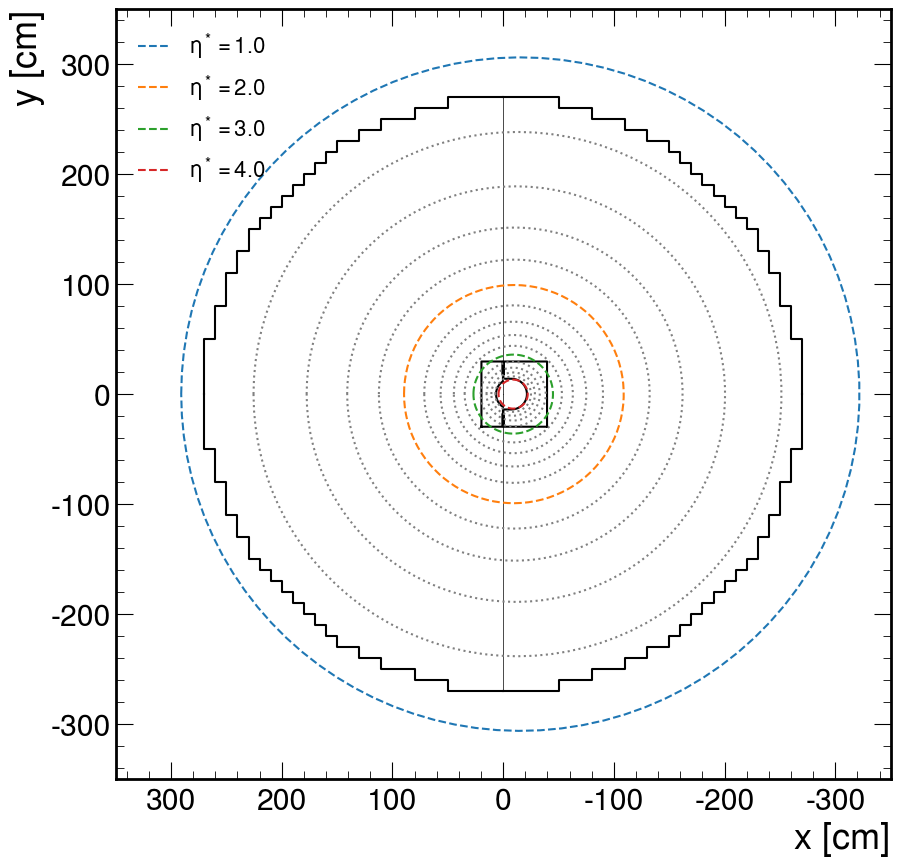

In [25]:
left_edges=pd.read_csv(f"insert_layout/PCB_edges_1L.csv")
right_edges=pd.read_csv(f"insert_layout/PCB_edges_1R.csv")
arg=dict(color='k')
plt.plot(left_edges.x, left_edges.y,**arg)
plt.plot(right_edges.x, right_edges.y,**arg)

#theta=np.linspace(0, 2*np.pi)
#plt.plot(540/2*np.cos(theta), 540/2*np.sin(theta), **arg)
for qx in -1,1:
    for qy in -1,1:
        a=(27, 27, 26, 26,25,25, 24,24,23,23,22,22,21,21,20,20,19,19,18,18,17,17,16,16,15,15,13,13,11,11,8,8,5,5,0)
        plt.plot(np.array(a)*10*qx, np.array(list(reversed(a)))*10*qy, **arg)

for s in -1,1:
    plt.plot((0,0),(s*540/2, s*.30),color='k', lw=0.5)

z=359.6
for i,eta in enumerate(np.linspace(1.0, 4.0, 16)):
    tanTheta=np.tan(2*np.arctan(np.exp(-eta)))
    phi= np.linspace(0, 2*np.pi, 100)
    uxp = tanTheta*np.cos(phi)
    uyp = tanTheta*np.sin(phi)
    uzp = 1

    beamTheta=-0.025
    ux = uxp*np.cos(beamTheta)+uzp*np.sin(beamTheta)
    uy = uyp
    uz = -uxp*np.sin(beamTheta)+uzp*np.cos(beamTheta)

    ux/=uz
    uy/=uz
    uz/=uz

    x,y = ux*z, uy*z
    plt.plot(x, y, marker='', color='0.5' if i%5!=0 else None, 
             ls='--' if i%5==0 else ':', label=f'$\\eta^*={eta:.1f}$' if i%5==0 else None)
plt.legend(fontsize=16)

plt.xlim(-350,350)
plt.ylim(-350,350)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.gca().invert_xaxis()

<class 'shapely.geometry.polygon.LinearRing'>


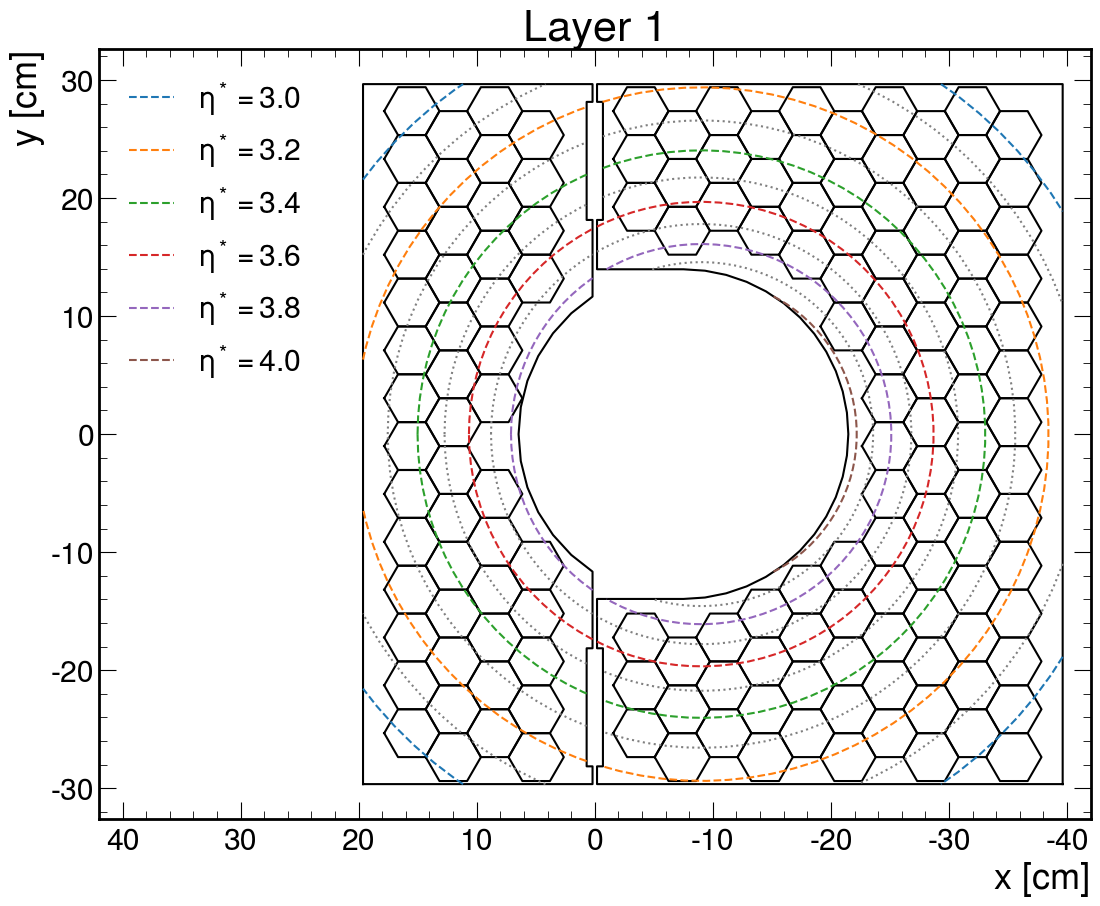

In [26]:
from shapely.geometry import Point, Polygon, MultiPolygon,LinearRing,LineString
from shapely.ops import unary_union


z=359.6
plt.figure(figsize=(14,10))

left_edges=pd.read_csv(f"insert_layout/PCB_edges_1L.csv")
right_edges=pd.read_csv(f"insert_layout/PCB_edges_1R.csv")

left_sipms=pd.read_csv("insert_layout/SiPM_positions_1L.csv")
right_sipms=pd.read_csv("insert_layout/SiPM_positions_1R.csv")



arg=dict(color='k')
plt.plot(left_edges.x, left_edges.y,**arg)
plt.plot(right_edges.x, right_edges.y,**arg)
#eta_plot(359.6)
phi=np.linspace(0, np.pi*2, 7)
for df in left_sipms, right_sipms:
    for i in range(len(df)):
        plt.plot(np.cos(phi)*hxrt(df.area[i])+df.x[i],np.sin(phi)*hxrt(df.area[i])+df.y[i], **arg)

acc=Polygon(zip(left_edges.x, left_edges.y)) | Polygon(zip(right_edges.x, right_edges.y))
print(type(acc.geoms[0].exterior))
colors='tab:blue tab:orange tab:green tab:red tab:purple tab:brown'.split()
for i,eta in enumerate(np.linspace(3.0, 4.0, 11)):
    tanTheta=np.tan(2*np.arctan(np.exp(-eta)))
    phi= np.linspace(0, 2*np.pi, 100)
    uxp = tanTheta*np.cos(phi)
    uyp = tanTheta*np.sin(phi)
    uzp = 1

    beamTheta=-0.025
    ux = uxp*np.cos(beamTheta)+uzp*np.sin(beamTheta)
    uy = uyp
    uz = -uxp*np.sin(beamTheta)+uzp*np.cos(beamTheta)

    ux/=uz
    uy/=uz
    uz/=uz

    x,y = ux*z, uy*z
    xy=LinearRing(zip(x,y))
    segments= (xy&acc)
    if type(segments)==LineString:
        segments=[segments]
    else:
        segments=segments.geoms
    first_seg=True
    for segment in segments:
        plt.plot(segment.xy[0],segment.xy[1], marker='', color='0.5' if i%2!=0 else colors[i//2], 
             ls='--' if i%2==0  else ':', label=f'$\\eta^*={eta:.1f}$' if i%2==0 and first_seg else None)
        first_seg=False

plt.xlim(42, -42)
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Layer 1")
plt.gca().set_aspect(1)
plt.legend(loc='upper left')
plt.show()

0.3786


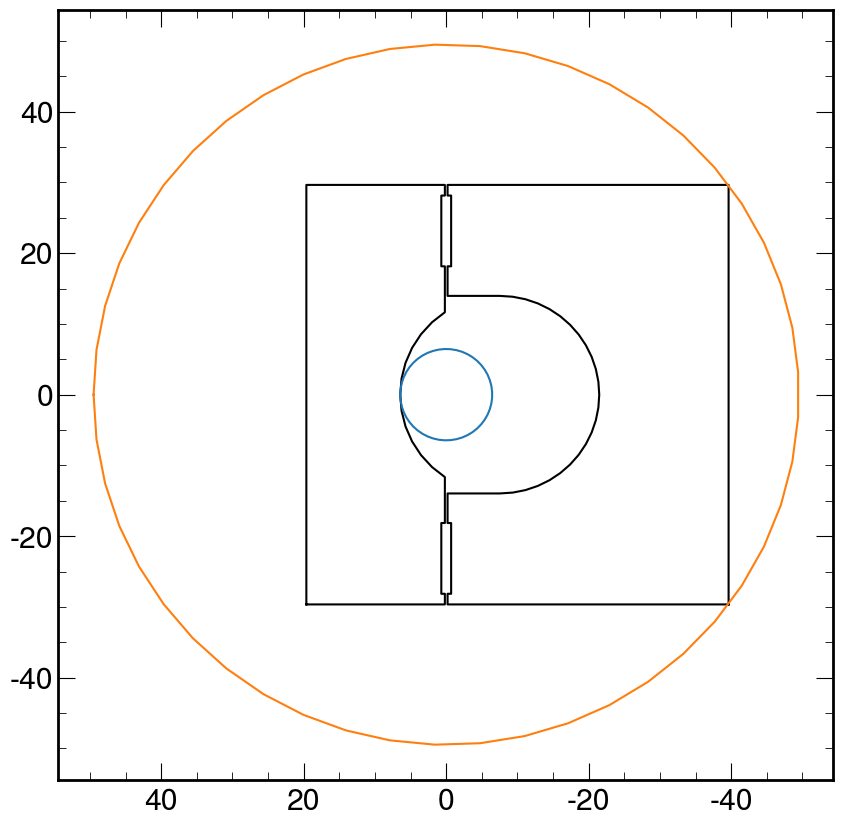

In [27]:
#show that generating events in a range in theta instead of theta* wastes computing time
left_edges=pd.read_csv(f"insert_layout/PCB_edges_1L.csv")
right_edges=pd.read_csv(f"insert_layout/PCB_edges_1R.csv")

rmin=min(left_edges.eval("sqrt(x**2+y**2)"))
rmax=max(right_edges.eval("sqrt(x**2+y**2)"))
arg=dict(color='k')
polys=[]
for edges in right_edges, left_edges:
    plt.plot(edges.x, edges.y, **arg)
    polys.append(Polygon(list(zip(edges.x, edges.y))))
phi=np.linspace(0, np.pi*2)
for r in rmin, rmax:
    plt.plot(r*np.cos(phi), r*np.sin(phi))
plt.gca().invert_xaxis()
detector=MultiPolygon(polys)

import random
rand=random.Random()
nhit=0
ntot=10000
for i in range(ntot):
    p=2
    r = np.sqrt(rand.uniform(rmin**2,rmax**2))
    phi=rand.uniform(0,np.pi*2)
    if detector.contains(Point(r*np.cos(phi), r*np.sin(phi))):
        nhit+=1
print(nhit/ntot)

In [28]:
max(left_edges.y)

29.645

In [29]:
100*12/25

48.0

(-5.0, 128.0, -35.0, 50.0)

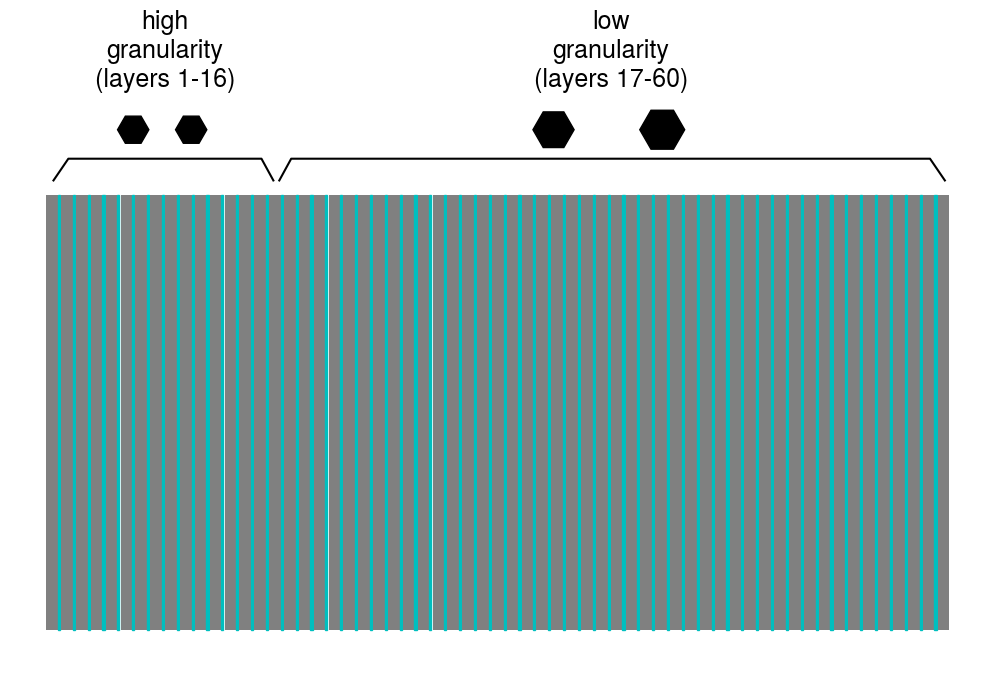

In [30]:
plt.figure(figsize=(14, 8))
for i in range(60):
    z=2.05*i
    plt.gca().add_patch(mpl.patches.Polygon(tuple(zip([z,z+1.6, z+1.6, z, z], [-30,-30, 30,30, -30])), color='0.5',ec='none'))
    plt.gca().add_patch(mpl.patches.Polygon(tuple(zip([z+1.9,z+1.6, z+1.6, z+1.9, z+1.9], [-30,-30, 30,30, -30])), color='c'))
i=60
z=2.05*i
plt.gca().add_patch(mpl.patches.Polygon(tuple(zip([z,z+1.6, z+1.6, z, z], [-30,-30, 30,30, -30])), color='0.5',ec='none'))
plt.plot(np.array((0, 1, 14,14.8))*2.05+1, (32, 35, 35, 32), color='k')
plt.plot(np.array((15.2, 16, 59,60))*2.05+1, (32, 35, 35, 32), color='k')
plt.gca().set_ylim(-35, 50)
plt.gca().set_xlim(-5, 128)
plt.gca().set_aspect(1)
plt.text(8*2.05, 45, "high\ngranularity\n(layers 1-16)", ha='center', fontsize=18)
plt.text(38*2.05, 45, "low\ngranularity\n(layers 17-60)", ha='center', fontsize=18)

#now draw hexagons to represent the cell sizes
phi=np.linspace(0, np.pi*2, 7)
x=12+2.16*np.cos(phi)
y=39+2.16*np.sin(phi)
plt.gca().add_patch(mpl.patches.Polygon(tuple(zip(x, y)), color='k'))
x=x+8
plt.gca().add_patch(mpl.patches.Polygon(tuple(zip(x, y)), color='k'))

x=70+2.84*np.cos(phi)
y=39+2.84*np.sin(phi)
plt.gca().add_patch(mpl.patches.Polygon(tuple(zip(x, y)), color='k'))

x=85+3.1*np.cos(phi)
y=39+3.1*np.sin(phi)
plt.gca().add_patch(mpl.patches.Polygon(tuple(zip(x, y)), color='k'))

plt.axis('off')

In [32]:
#Differential pairs with 200 μm traces, 200 μm between them, with 500 μm between them → 1.1 mm per signal



In [33]:
sum(summary.query("layer>35 and side=='R'").channels)

In [34]:
help(mpl.patches.Polygon.__init__)

In [35]:
120/1.1

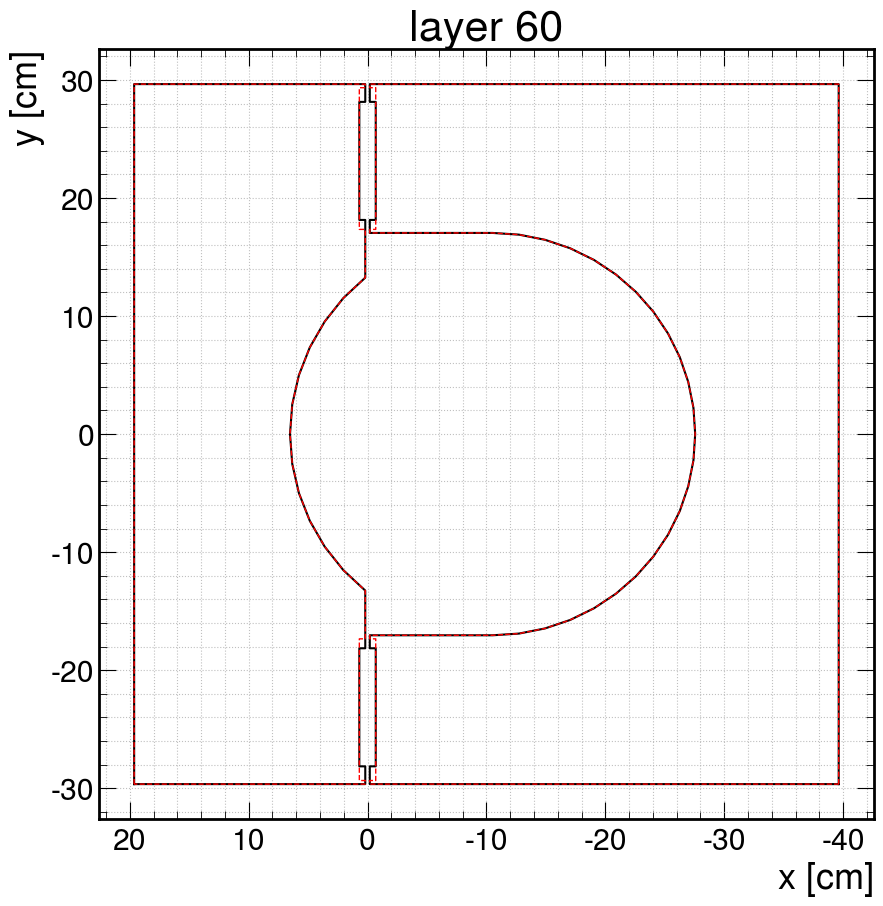

In [33]:
left_edges=pd.read_csv(f"insert_layout/PCB_edges_60L.csv")
right_edges=pd.read_csv(f"insert_layout/PCB_edges_60R.csv")
arg1=dict(color='k')
arg2=dict(color='r', ls='--',lw=1)
for edges in right_edges, left_edges:
    plt.plot(edges.x, edges.y, **arg1)
    #update the edge posititons
    y_new = edges.y+np.sign(edges.y)*(1.2*((abs(edges.y)>28)&(abs(edges.y)<29))-0.8*((abs(edges.y)<20)&(abs(edges.y)>18)))
    plt.plot(edges.x, y_new, **arg2)
plt.title("layer 60")    
plt.grid(which='both')
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.gca().invert_xaxis()

# miscellaneous code

In [35]:
# print out the side lengths that would fit an integer number of hexagons vertically with such and such margin.  
for i in range(16*2, 36*2):
    sl= (2*max(real_bounds.exterior.xy[1])-.4)/(i*np.sqrt(3)/4)
    print(i,sl, hexed(sl))

32 4.250019669072133 46.928185933435856
33 4.121231194251766 44.12714636899755
34 4.000018512067889 41.56960414864906
35 3.88573226886595 39.22813256803128
36 3.7777952613974515 37.07906049061598
37 3.675692686765088 35.10187172815071
38 3.5789639318502173 33.278713570525156
39 3.4871956259053394 31.59399237070237
40 3.4000157352577065 30.03403899739895
41 3.3170885222026403 28.586830693538555
42 3.238110224054958 27.241758727799496
43 3.1628053351234477 25.98943342122137
44 3.090923395688824 24.821519832561115
45 3.022236209117961 23.730598713994233
46 2.956535421963223 22.710048391227943
47 2.893630412985282 21.753944045196157
48 2.8333464460480884 20.85697152597149
49 2.7755230491899643 20.014353351036366
50 2.720012588206165 19.22178495833533
51 2.6666790080452603 18.475379621621812
52 2.615396719429005 17.77162070852009
53 2.56604961151525 17.107320183637707
54 2.518530174264968 16.479582440273777
55 2.472738716551059 15.885772692839113
56 2.428582668041219 15.32348928438722
57 2.

In [36]:
#print out the hex roots of several different numbers:
hexed(3.1), hexed(2.84), hexed(2.34)

(24.96751239110537, 20.955043490291303, 14.226026102886212)